In [1]:
# ===============================================================================
# Data Table Preview Script - Display the First 5 Rows of All Key Data Tables
# ===============================================================================

import pandas as pd
import os

# Set working directory
base_dir = "/Users/heweilin/Desktop/P056_Code/"

print("=" * 80)
print("Data Table Preview Script")
print("=" * 80)

# List of data files to check
data_files = {
    "DEG Data": "Data/1mRNA_DEGs_proteincoding.csv",
    "DEmiR Data": "Data/2miRNA_DEmirs.csv", 
    "DMR Data": "Data/4DNA_DMRs.csv",
    "mRNA Expression Data": "Data/5mRNA_TPM.csv",
    "miRNA Expression Data": "Data/6miRNA_TPM.csv",
    "Clinical Data": "Data/7Clinical_data50.csv"
}

# Read and display the first 5 rows for each file
for name, file_path in data_files.items():
    full_path = os.path.join(base_dir, file_path)
    
    print(f"\n{'='*20} {name} {'='*20}")
    print(f"File path: {file_path}")
    
    try:
        # Load the data
        df = pd.read_csv(full_path)
        print(f"Shape: {df.shape}")
        print(f"Column names: {list(df.columns)}")
        print("\nFirst 5 rows:")
        print(df.head())
        
    except Exception as e:
        print(f"Failed to read: {e}")

print(f"\n{'='*80}")
print("Data preview complete")
print("="*80)


Data Table Preview Script

==================== DEG Data ====================
File path: Data/1mRNA_DEGs_proteincoding.csv
Shape: (19853, 13)
Column names: ['Row.names', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj', 'Chromosome', 'Gene_start', 'Gene_end', 'Strand', 'Gene_type', 'SYMBOL']

First 5 rows:
         Row.names  baseMean  log2FoldChange     lfcSE      stat  \
0  ENSG00000181626  0.246273      -30.000000  4.018503 -7.465467   
1  ENSG00000162624  0.663988       29.910834  4.005070  7.468243   
2  ENSG00000123561  3.410848       29.936702  4.007002  7.471098   
3  ENSG00000227234  5.145687       29.993455  4.007089  7.485098   
4  ENSG00000106927  9.796323       30.000000  4.001335  7.497498   

         pvalue          padj Chromosome  Gene_start   Gene_end  Strand  \
0  8.300000e-14  2.790000e-10         18    12093843   12129764       1   
1  8.130000e-14  2.790000e-10          1    75128434   75161533       1   
2  7.950000e-14  2.790000e-10          X   

/var/folders/6r/vh9hm9y50sng_kp683fc7t8m0000gn/T/ipykernel_61818/2023799310.py:34: DtypeWarning: Columns (1,18,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path)


Shape: (493648, 25)
Column names: ['Unnamed: 0', 'annot.tx_id', 'seqnames', 'start', 'end', 'width', 'strand', 'name', 'pvalue', 'qvalue', 'meth.diff', 'annot.seqnames', 'annot.start', 'annot.end', 'annot.width', 'annot.strand', 'annot.id', 'annot.gene_id', 'annot.symbol', 'annot.type', 'Gene.stable.ID', 'Gene.stable.ID.version', 'Transcript.stable.ID', 'HGNC.symbol', 'DiffMethylated']

First 5 rows:
   Unnamed: 0         annot.tx_id seqnames      start        end  width  \
0           1  ENST00000000233.10     chr7  127590002  127591000    999   
1           2  ENST00000000233.10     chr7  127590002  127591000    999   
2           3  ENST00000000233.10     chr7  127590002  127591000    999   
3           4  ENST00000000233.10     chr7  127590002  127591000    999   
4           9  ENST00000000442.11    chr11   64311002   64312000    999   

  strand name        pvalue        qvalue  ...  annot.strand       annot.id  \
0      *    *  4.693904e-06  2.343401e-05  ...             +    ex

In [17]:
# ===============================================================================
# CpG-miRNA-mRNA Mediation Analysis
# Analyzing how DNA methylation regulates mRNA expression through miRNA
# ===============================================================================

import pandas as pd
import numpy as np
import os
import warnings
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import datetime
import re

# Suppress warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Set working directory
base_dir = "/Users/heweilin/Desktop/P056_Code/"
output_dir = os.path.join(base_dir, "Data_Post_Processed/")
figure_dir = os.path.join(base_dir, "Figure/")

Path(output_dir).mkdir(parents=True, exist_ok=True)
Path(figure_dir).mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("Complete CpG-miRNA-mRNA Mediation Analysis with Corrected ID Matching")
print("=" * 80)

# ===============================================================================
# Step 1: Data Loading and ID Matching Verification
# ===============================================================================

def load_and_verify_data():
    """Load data and verify ID matching between datasets"""
    
    print("\nStep 1: Data Loading and ID Matching Verification")
    print("-" * 50)
    
    try:
        # Load all required datasets
        degs = pd.read_csv(os.path.join(base_dir, "Data/1mRNA_DEGs_proteincoding.csv"))
        demirs = pd.read_csv(os.path.join(base_dir, "Data/2miRNA_DEmirs.csv"))
        dmrs = pd.read_csv(os.path.join(base_dir, "Data/4DNA_DMRs.csv"))
        clinical = pd.read_csv(os.path.join(base_dir, "Data/7Clinical_data50.csv"))
        mrna_tpm = pd.read_csv(os.path.join(base_dir, "Data/5mRNA_TPM.csv"))
        mirna_tpm = pd.read_csv(os.path.join(base_dir, "Data/6miRNA_TPM.csv"))
        
        print("✓ All data files loaded successfully")
        print(f"  - DEG data: {degs.shape}")
        print(f"  - DEmiR data: {demirs.shape}")
        print(f"  - DMR data: {dmrs.shape}")
        print(f"  - Clinical data: {clinical.shape}")
        print(f"  - mRNA expression data: {mrna_tpm.shape}")
        print(f"  - miRNA expression data: {mirna_tpm.shape}")
        
    except Exception as e:
        print(f"❌ Data loading failed: {e}")
        return None
    
    print("\nVerifying gene ID matching...")
    
    # Extract gene/miRNA identifiers from each dataset
    deg_genes = set(degs['Row.names'].dropna().astype(str))  # Using Row.names column
    matrix_genes = set(mrna_tpm['Unnamed: 0'].dropna().astype(str))  # Expression matrix first column
    dmr_genes = set(dmrs['Gene.stable.ID'].dropna().astype(str))  # Gene IDs in DMRs
    
    demir_names = set(demirs['Unnamed: 0'].dropna().astype(str))  # DEmiR names
    mirna_matrix_names = set(mirna_tpm['sRNA'].dropna().astype(str))  # miRNA expression matrix
    
    # Calculate overlap rates
    deg_matrix_overlap = deg_genes & matrix_genes
    deg_dmr_overlap = deg_genes & dmr_genes
    demir_mirna_overlap = demir_names & mirna_matrix_names
    
    print(f"Gene ID matching verification:")
    print(f"  DEG genes: {len(deg_genes)}")
    print(f"  mRNA expression matrix genes: {len(matrix_genes)}")
    print(f"  DEG-Expression matrix overlap: {len(deg_matrix_overlap)} ({len(deg_matrix_overlap)/len(deg_genes)*100:.1f}%)")
    print(f"  DEG-DMR overlap: {len(deg_dmr_overlap)} ({len(deg_dmr_overlap)/len(deg_genes)*100:.1f}%)")
    
    print(f"\nmiRNA matching verification:")
    print(f"  DEmiRs: {len(demir_names)}")
    print(f"  miRNA expression matrix: {len(mirna_matrix_names)}")
    print(f"  DEmiR-Expression matrix overlap: {len(demir_mirna_overlap)} ({len(demir_mirna_overlap)/len(demir_names)*100:.1f}%)")
    
    return {
        'degs': degs,
        'demirs': demirs,
        'dmrs': dmrs,
        'clinical': clinical,
        'mrna_tpm': mrna_tpm,
        'mirna_tpm': mirna_tpm,
        'matching_stats': {
            'deg_matrix_overlap': len(deg_matrix_overlap),
            'deg_dmr_overlap': len(deg_dmr_overlap),
            'demir_mirna_overlap': len(demir_mirna_overlap)
        }
    }

data = load_and_verify_data()
if data is None:
    print("Data loading failed, exiting program")
    exit()

# ===============================================================================
# Step 2: Sample Intersection Analysis
# ===============================================================================

def analyze_sample_intersection(clinical_data, mrna_tpm, mirna_tpm):
    """Analyze sample intersection across datasets"""
    
    print("\nStep 2: Sample Intersection Analysis")
    print("-" * 50)
    
    def extract_base_id(sample_id):
        """Extract base patient ID from sample identifier"""
        if pd.isna(sample_id):
            return None
        sample_str = str(sample_id)
        match = re.search(r'P\d+', sample_str)
        if match:
            # Remove letter suffixes (e.g., P001a -> P001)
            return re.sub(r'[a-zA-Z]$', '', match.group())
        return None
    
    # Extract sample IDs from each dataset
    clinical_samples = set()
    for _, row in clinical_data.iterrows():
        base_id = extract_base_id(row['mRNA_ID'])
        if base_id:
            clinical_samples.add(base_id)
    
    mrna_samples = set()
    for col in mrna_tpm.columns[1:]:  # Skip 'Unnamed: 0'
        base_id = extract_base_id(col)
        if base_id:
            mrna_samples.add(base_id)
    
    mirna_samples = set()
    for col in mirna_tpm.columns[1:]:  # Skip 'sRNA'
        base_id = extract_base_id(col)
        if base_id:
            mirna_samples.add(base_id)
    
    # Calculate intersection
    intersection_all = clinical_samples & mrna_samples & mirna_samples
    
    print(f"Sample matching statistics:")
    print(f"  Clinical data samples: {len(clinical_samples)}")
    print(f"  mRNA expression samples: {len(mrna_samples)}")
    print(f"  miRNA expression samples: {len(mirna_samples)}")
    print(f"  Three-way intersection: {len(intersection_all)}")
    
    if len(intersection_all) > 0:
        # Check B12 status distribution
        intersection_clinical = clinical_data[
            clinical_data['mRNA_ID'].apply(extract_base_id).isin(intersection_all)
        ]
        
        print(f"\nB12 status distribution:")
        b12_counts = intersection_clinical['B12_status'].value_counts()
        for status, count in b12_counts.items():
            print(f"  {status}: {count}")
        
        print(f"\nB12 concentration statistics:")
        b12_stats = intersection_clinical['B12_mol'].describe()
        print(f"  Mean: {b12_stats['mean']:.2f}")
        print(f"  Std: {b12_stats['std']:.2f}")
        print(f"  Range: {b12_stats['min']:.2f} - {b12_stats['max']:.2f}")
        
        return intersection_all, intersection_clinical
    else:
        print("❌ No common samples found across all three datasets!")
        return set(), pd.DataFrame()

common_samples, common_clinical = analyze_sample_intersection(
    data['clinical'], data['mrna_tpm'], data['mirna_tpm']
)

if len(common_samples) == 0:
    print("Cannot continue analysis without common samples")
    exit()

# ===============================================================================
# Step 3: Corrected Triplet Construction
# ===============================================================================

def build_corrected_triplets(degs_data, demirs_data, dmrs_data):
    """Build triplets using correct ID matching"""
    
    print("\nStep 3: Corrected Triplet Construction")
    print("-" * 50)
    
    # Filter significant DEGs and DEmiRs
    if 'padj' in degs_data.columns:
        sig_degs = degs_data[degs_data['padj'] < 0.05].copy()
    else:
        sig_degs = degs_data[degs_data['pvalue'] < 0.05].copy()
    
    # For DEmiRs, use uncorrected p-value (p < 0.05) as selection criterion
    # This is because miRNA expression levels are generally low, regulatory effects are weak,
    # and study sample size is limited
    sig_demirs = demirs_data[demirs_data['pvalue'] < 0.05].copy()
    
    print(f"Significant differential data:")
    print(f"  Significant DEGs: {len(sig_degs)}")
    print(f"  Significant DEmiRs: {len(sig_demirs)}")
    
    # Add miRNA name column to DEmiR data
    sig_demirs['miRNA_Name'] = sig_demirs['Unnamed: 0']
    
    triplets = []
    genes_with_dmr = 0
    
    # Build triplets: for each significant DEG, check if it has DMRs, then pair with each DEmiR
    for _, deg_row in sig_degs.iterrows():
        gene_ensembl_id = deg_row['Row.names']  # Use Ensembl ID
        gene_symbol = deg_row['SYMBOL']  # For display
        
        # Find this gene in DMR data (using Gene.stable.ID column)
        gene_dmrs = dmrs_data[dmrs_data['Gene.stable.ID'] == gene_ensembl_id]
        
        if len(gene_dmrs) > 0:
            genes_with_dmr += 1
            
            # Create triplets for each DEmiR
            for _, demir_row in sig_demirs.iterrows():
                mirna_name = demir_row['miRNA_Name']
                
                # Create triplets for each significant DMR of this gene (limit to avoid combinatorial explosion)
                for dmr_idx, dmr_row in gene_dmrs.head(3).iterrows():
                    triplet = {
                        'Triplet_ID': f"{gene_symbol}_{mirna_name}_{dmr_idx}",
                        'Gene_Ensembl_ID': gene_ensembl_id,    # For expression matrix matching
                        'Gene_Symbol': gene_symbol,            # For display
                        'miRNA_Name': mirna_name,              # For miRNA expression matrix matching
                        'DMR_Index': dmr_idx,
                        
                        # DEG information
                        'Target_log2FC': deg_row['log2FoldChange'],
                        'Target_Direction': 'Up-regulated' if deg_row['log2FoldChange'] > 0 else 'Down-regulated',
                        'Target_padj': deg_row.get('padj', deg_row.get('pvalue', 1.0)),
                        
                        # DEmiR information
                        'miRNA_log2FC': demir_row['log2FoldChange'],
                        'miRNA_Direction': 'Up-regulated' if demir_row['log2FoldChange'] > 0 else 'Down-regulated',
                        'miRNA_padj': demir_row.get('padj', demir_row.get('pvalue', 1.0)),
                        
                        # DMR information
                        'Methylation_Direction': 'Hypermethylated' if dmr_row['meth.diff'] > 0 else 'Hypomethylated',
                        'Methylation_Value': dmr_row['meth.diff'],
                        'DMR_pvalue': dmr_row['pvalue'],
                        'DMR_qvalue': dmr_row['qvalue']
                    }
                    triplets.append(triplet)
    
    triplets_df = pd.DataFrame(triplets)
    
    print(f"\nTriplet construction results:")
    print(f"  Significant genes with DMRs: {genes_with_dmr}")
    print(f"  Successfully constructed triplets: {len(triplets_df)}")
    
    if len(triplets_df) > 0:
        print(f"  Unique genes involved: {triplets_df['Gene_Symbol'].nunique()}")
        print(f"  Unique miRNAs involved: {triplets_df['miRNA_Name'].nunique()}")
        
        print(f"\nMethylation direction distribution:")
        meth_counts = triplets_df['Methylation_Direction'].value_counts()
        for direction, count in meth_counts.items():
            print(f"  {direction}: {count}")
        
        print(f"\nmiRNA regulation direction distribution:")
        mirna_counts = triplets_df['miRNA_Direction'].value_counts()
        for direction, count in mirna_counts.items():
            print(f"  {direction}: {count}")
        
        print(f"\nTarget gene expression direction distribution:")
        target_counts = triplets_df['Target_Direction'].value_counts()
        for direction, count in target_counts.items():
            print(f"  {direction}: {count}")
    
    return triplets_df

mediation_triplets = build_corrected_triplets(data['degs'], data['demirs'], data['dmrs'])

if len(mediation_triplets) == 0:
    print("Cannot build triplets, please check data")
    exit()

# ===============================================================================
# Step 4: Prepare Expression Data (Using Correct ID Matching)
# ===============================================================================

def prepare_expression_data(mrna_tpm, mirna_tpm, common_samples_set):
    """Prepare expression data using correct IDs"""
    
    print("\nStep 4: Prepare Expression Data")
    print("-" * 50)
    
    def extract_base_id(sample_id):
        """Extract base patient ID from sample identifier"""
        if pd.isna(sample_id):
            return None
        sample_str = str(sample_id)
        match = re.search(r'P\d+', sample_str)
        if match:
            return re.sub(r'[a-zA-Z]$', '', match.group())
        return None
    
    # Filter mRNA expression data
    mrna_cols_to_keep = ['Unnamed: 0']  # Gene ID column
    mrna_sample_mapping = {}
    
    for col in mrna_tpm.columns[1:]:
        base_id = extract_base_id(col)
        if base_id in common_samples_set:
            mrna_cols_to_keep.append(col)
            mrna_sample_mapping[col] = base_id
    
    # Filter miRNA expression data
    mirna_cols_to_keep = ['sRNA']  # miRNA ID column
    mirna_sample_mapping = {}
    
    for col in mirna_tpm.columns[1:]:
        base_id = extract_base_id(col)
        if base_id in common_samples_set:
            mirna_cols_to_keep.append(col)
            mirna_sample_mapping[col] = base_id
    
    # Create filtered expression matrices
    mrna_filtered = mrna_tpm[mrna_cols_to_keep].copy()
    mirna_filtered = mirna_tpm[mirna_cols_to_keep].copy()
    
    print(f"Expression data filtering results:")
    print(f"  Filtered mRNA data: {mrna_filtered.shape}")
    print(f"  Filtered miRNA data: {mirna_filtered.shape}")
    print(f"  Common samples: {len(mrna_sample_mapping)}")
    
    # Convert to analysis format
    mrna_genes = mrna_filtered['Unnamed: 0'].values
    mrna_samples = mrna_filtered.columns[1:].values
    mrna_matrix = mrna_filtered.set_index('Unnamed: 0').values.T  # Transpose: samples x genes
    
    mirna_names = mirna_filtered['sRNA'].values  
    mirna_samples = mirna_filtered.columns[1:].values
    mirna_matrix = mirna_filtered.set_index('sRNA').values.T  # Transpose: samples x miRNAs
    
    print(f"  mRNA matrix dimensions: {mrna_matrix.shape} (samples x genes)")
    print(f"  miRNA matrix dimensions: {mirna_matrix.shape} (samples x miRNAs)")
    
    return {
        'mrna_genes': mrna_genes,
        'mrna_samples': mrna_samples,
        'mrna_matrix': mrna_matrix,
        'mrna_sample_mapping': mrna_sample_mapping,
        'mirna_names': mirna_names,
        'mirna_samples': mirna_samples,
        'mirna_matrix': mirna_matrix,
        'mirna_sample_mapping': mirna_sample_mapping
    }

expr_data = prepare_expression_data(data['mrna_tpm'], data['mirna_tpm'], common_samples)

# ===============================================================================
# Step 5: Prepare Clinical Data
# ===============================================================================

def prepare_clinical_data(clinical_data, common_samples_set):
    """Prepare clinical data for analysis"""
    
    print("\nStep 5: Prepare Clinical Data")
    print("-" * 50)
    
    def extract_base_id(sample_id):
        """Extract base patient ID from sample identifier"""
        if pd.isna(sample_id):
            return None
        sample_str = str(sample_id)
        match = re.search(r'P\d+', sample_str)
        if match:
            return re.sub(r'[a-zA-Z]$', '', match.group())
        return None
    
    clinical_data['Base_ID'] = clinical_data['mRNA_ID'].apply(extract_base_id)
    sample_info = clinical_data[clinical_data['Base_ID'].isin(common_samples_set)].copy()
    
    # Prepare B12 variables
    sample_info['B12_numeric'] = sample_info['B12_mol']
    sample_info['B12_binary'] = sample_info['B12_status'].map(lambda x: 1 if x == 'LB' else 0)
    
    print(f"Clinical data preparation results:")
    print(f"  Filtered samples: {len(sample_info)}")
    
    print(f"  B12 status distribution:")
    b12_status_counts = sample_info['B12_status'].value_counts()
    for status, count in b12_status_counts.items():
        print(f"    {status}: {count}")
    
    print(f"  B12 binary variable distribution:")
    b12_binary_counts = sample_info['B12_binary'].value_counts()
    for value, count in b12_binary_counts.items():
        status_name = "LB (Low B12)" if value == 1 else "NB (Normal B12)"
        print(f"    {value} ({status_name}): {count}")
    
    print(f"  B12 concentration statistics:")
    b12_stats = sample_info['B12_numeric'].describe()
    print(f"    Mean: {b12_stats['mean']:.2f}")
    print(f"    Std: {b12_stats['std']:.2f}")
    print(f"    Range: {b12_stats['min']:.2f} - {b12_stats['max']:.2f}")
    
    # Check variability
    b12_numeric_var = sample_info['B12_numeric'].var()
    b12_binary_var = sample_info['B12_binary'].var()
    print(f"  B12 numeric variable variance: {b12_numeric_var:.2f}")
    print(f"  B12 binary variable variance: {b12_binary_var:.2f}")
    
    return sample_info

sample_info = prepare_clinical_data(data['clinical'], common_samples)

# ===============================================================================
# Step 6: Corrected Mediation Analyzer
# ===============================================================================

class CorrectedMediationAnalyzer:
    """Corrected mediation analysis class"""
    
    def __init__(self, expr_data, sample_data):
        self.expr_data = expr_data
        self.sample_data = sample_data
        
        # Diagnostic tracking
        self.diagnosis = {
            'total_attempts': 0,
            'gene_not_found': 0,
            'mirna_not_found': 0,
            'insufficient_samples': 0,
            'no_variance': 0,
            'model_error': 0,
            'successful': 0
        }
    
    def perform_mediation_analysis(self, triplet_data, debug=False):
        """Perform mediation analysis for a single triplet"""
        
        self.diagnosis['total_attempts'] += 1
        
        gene_ensembl_id = triplet_data['Gene_Ensembl_ID']  # Use Ensembl ID
        gene_symbol = triplet_data['Gene_Symbol']
        mirna_name = triplet_data['miRNA_Name']
        
        if debug:
            print(f"\n=== Analyzing triplet: {gene_symbol} ({gene_ensembl_id}) - {mirna_name} ===")
        
        try:
            # 1. Check if gene exists in expression matrix
            if gene_ensembl_id not in self.expr_data['mrna_genes']:
                if debug:
                    print(f"❌ Gene {gene_ensembl_id} not found in mRNA expression matrix")
                self.diagnosis['gene_not_found'] += 1
                return None
            
            # 2. Check if miRNA exists in expression matrix
            if mirna_name not in self.expr_data['mirna_names']:
                if debug:
                    print(f"❌ miRNA {mirna_name} not found in miRNA expression matrix")
                self.diagnosis['mirna_not_found'] += 1
                return None
            
            if debug:
                print(f"✓ Both gene and miRNA found in expression matrices")
            
            # 3. Get expression data indices
            gene_idx = np.where(self.expr_data['mrna_genes'] == gene_ensembl_id)[0][0]
            mirna_idx = np.where(self.expr_data['mirna_names'] == mirna_name)[0][0]
            
            # 4. Build analysis dataframe
            analysis_data = []
            
            # Match samples
            mrna_samples = self.expr_data['mrna_samples']
            mirna_samples = self.expr_data['mirna_samples']
            mrna_mapping = self.expr_data['mrna_sample_mapping']
            mirna_mapping = self.expr_data['mirna_sample_mapping']
            
            for i, mrna_sample in enumerate(mrna_samples):
                mrna_base_id = mrna_mapping[mrna_sample]
                
                # Find corresponding miRNA sample
                mirna_sample_idx = None
                for j, mirna_sample in enumerate(mirna_samples):
                    if mirna_mapping[mirna_sample] == mrna_base_id:
                        mirna_sample_idx = j
                        break
                
                if mirna_sample_idx is not None:
                    # Find corresponding clinical data
                    clinical_row = self.sample_data[self.sample_data['Base_ID'] == mrna_base_id]
                    
                    if len(clinical_row) > 0:
                        clinical_info = clinical_row.iloc[0]
                        analysis_data.append({
                            'Sample': mrna_base_id,
                            'mRNA_expr': self.expr_data['mrna_matrix'][i, gene_idx],
                            'miRNA_expr': self.expr_data['mirna_matrix'][mirna_sample_idx, mirna_idx],
                            'B12_numeric': clinical_info['B12_numeric'],
                            'B12_binary': clinical_info['B12_binary'],
                            'Age': clinical_info['age'],
                            'BMI': clinical_info['BMI']
                        })
            
            if len(analysis_data) < 10:
                if debug:
                    print(f"❌ Insufficient samples: {len(analysis_data)} < 10")
                self.diagnosis['insufficient_samples'] += 1
                return None
            
            # 5. Create analysis DataFrame
            df = pd.DataFrame(analysis_data)
            df = df.dropna()
            
            if debug:
                print(f"Matched samples: {len(df)}")
                print(f"B12 binary distribution: {df['B12_binary'].value_counts().to_dict()}")
            
            if len(df) < 10:
                if debug:
                    print(f"❌ Insufficient samples after removing missing values")
                self.diagnosis['insufficient_samples'] += 1
                return None
            
            # 6. Check variance and select B12 variable
            b12_numeric_var = df['B12_numeric'].var()
            b12_binary_var = df['B12_binary'].var()
            
            if b12_numeric_var > 0:
                b12_var = 'B12_numeric'
                if debug:
                    print(f"✓ Using B12 concentration (variance: {b12_numeric_var:.3f})")
            elif b12_binary_var > 0:
                b12_var = 'B12_binary'
                if debug:
                    print(f"✓ Using B12 binary variable (variance: {b12_binary_var:.3f})")
            else:
                if debug:
                    print(f"❌ No variance in B12 variables")
                self.diagnosis['no_variance'] += 1
                return None
            
            # Check expression data variance
            if df['mRNA_expr'].var() == 0 or df['miRNA_expr'].var() == 0:
                if debug:
                    print(f"❌ No variance in expression data")
                self.diagnosis['no_variance'] += 1
                return None
            
            # 7. Standardize covariates
            scaler = StandardScaler()
            df['Age_scaled'] = scaler.fit_transform(df[['Age']])[:, 0]
            df['BMI_scaled'] = scaler.fit_transform(df[['BMI']])[:, 0]
            
            # 8. Perform mediation analysis
            X = df[b12_var].values
            M = df['miRNA_expr'].values
            Y = df['mRNA_expr'].values
            Age = df['Age_scaled'].values
            BMI = df['BMI_scaled'].values
            
            # Path analysis
            # Path a: X -> M (controlling for age and BMI)
            predictors_m = np.column_stack([X, Age, BMI])
            reg_m = LinearRegression().fit(predictors_m, M)
            path_a = reg_m.coef_[0]
            r2_mediator = r2_score(M, reg_m.predict(predictors_m))
            
            # Path b: X + M -> Y (controlling for age and BMI)
            predictors_y = np.column_stack([X, M, Age, BMI])
            reg_y = LinearRegression().fit(predictors_y, Y)
            path_b = reg_y.coef_[1]  # M to Y coefficient
            path_c_prime = reg_y.coef_[0]  # Direct effect
            r2_outcome = r2_score(Y, reg_y.predict(predictors_y))
            
            # Total effect: X -> Y (controlling for age and BMI)
            predictors_direct = np.column_stack([X, Age, BMI])
            reg_direct = LinearRegression().fit(predictors_direct, Y)
            path_c = reg_direct.coef_[0]  # Total effect
            
            # Mediation effect
            acme = path_a * path_b  # Indirect effect (Average Causal Mediation Effect)
            total_effect = path_c
            prop_mediated = acme / total_effect if total_effect != 0 else 0
            
            # Calculate p-values
            n = len(df)
            se_a = np.sqrt(np.sum((M - reg_m.predict(predictors_m))**2) / (n-4)) / np.sqrt(np.sum((X - np.mean(X))**2))
            se_b = np.sqrt(np.sum((Y - reg_y.predict(predictors_y))**2) / (n-5)) / np.sqrt(np.sum((M - np.mean(M))**2))
            
            t_a = path_a / se_a if se_a > 0 else 0
            t_b = path_b / se_b if se_b > 0 else 0
            
            p_a = 2 * (1 - stats.t.cdf(abs(t_a), n-4))
            p_b = 2 * (1 - stats.t.cdf(abs(t_b), n-5))
            
            if debug:
                print(f"✓ Mediation analysis completed")
                print(f"  Path a: {path_a:.4f} (p={p_a:.4f})")
                print(f"  Path b: {path_b:.4f} (p={p_b:.4f})")
                print(f"  ACME: {acme:.4f}")
                print(f"  Total Effect: {total_effect:.4f}")
                print(f"  Proportion Mediated: {prop_mediated:.4f}")
            
            self.diagnosis['successful'] += 1
            
            # Return results
            return {
                'Triplet_ID': triplet_data['Triplet_ID'],
                'Gene_Ensembl_ID': gene_ensembl_id,
                'Gene_Symbol': gene_symbol,
                'miRNA_Name': mirna_name,
                'Sample_Size': len(df),
                'B12_Variable_Used': b12_var,
                
                # Original differential information
                'Target_log2FC': triplet_data['Target_log2FC'],
                'Target_Direction': triplet_data['Target_Direction'],
                'miRNA_log2FC': triplet_data['miRNA_log2FC'],
                'miRNA_Direction': triplet_data['miRNA_Direction'],
                'Methylation_Direction': triplet_data['Methylation_Direction'],
                'Methylation_Value': triplet_data['Methylation_Value'],
                
                # Mediation analysis results
                'Path_a': path_a,
                'Path_a_pvalue': p_a,
                'Path_b': path_b,
                'Path_b_pvalue': p_b,
                'Path_c': path_c,
                'Path_c_prime': path_c_prime,
                'ACME': acme,
                'Total_Effect': total_effect,
                'Proportion_Mediated': prop_mediated,
                'R2_Mediator': r2_mediator,
                'R2_Outcome': r2_outcome,
                
                # Significance determination
                'Path_a_Significant': p_a < 0.05,
                'Path_b_Significant': p_b < 0.05,
                'Mediation_Significant': (p_a < 0.05) and (p_b < 0.05)
            }
            
        except Exception as e:
            if debug:
                print(f"❌ Error during analysis: {e}")
            self.diagnosis['model_error'] += 1
            return None
    
    def batch_analysis(self, triplets_df, max_triplets=None, debug_first=3):
        """Perform batch mediation analysis"""
        
        print(f"\nStep 7: Batch Mediation Analysis")
        print("-" * 50)
        
        if max_triplets:
            triplets_to_analyze = triplets_df.head(max_triplets)
            print(f"Analyzing first {max_triplets} triplets")
        else:
            triplets_to_analyze = triplets_df
            print(f"Analyzing all {len(triplets_df)} triplets")
        
        results = []
        
        for idx, (_, triplet_row) in enumerate(triplets_to_analyze.iterrows()):
            # Show detailed debug info for first few triplets
            debug_mode = idx < debug_first
            
            if idx % 100 == 0 and idx > 0:
                print(f"Progress: {idx}/{len(triplets_to_analyze)} ({idx/len(triplets_to_analyze)*100:.1f}%)")
                print(f"Current successes: {len(results)}")
            
            result = self.perform_mediation_analysis(triplet_row, debug=debug_mode)
            if result is not None:
                results.append(result)
        
        print(f"\n=== Batch Analysis Complete ===")
        print(f"Diagnostic statistics:")
        for key, value in self.diagnosis.items():
            print(f"  {key}: {value}")
        
        if self.diagnosis['total_attempts'] > 0:
            success_rate = self.diagnosis['successful'] / self.diagnosis['total_attempts'] * 100
            print(f"Success rate: {success_rate:.1f}%")
        
        return pd.DataFrame(results) if results else pd.DataFrame()

# ===============================================================================
# Step 7: Execute Mediation Analysis
# ===============================================================================

# Create analyzer and perform analysis
analyzer = CorrectedMediationAnalyzer(expr_data, sample_info)

# Perform batch analysis (adjust max_triplets parameter to control analysis size)
mediation_results = analyzer.batch_analysis(mediation_triplets, max_triplets=100, debug_first=3)

# ===============================================================================
# Step 8: Results Analysis and Reporting
# ===============================================================================

def analyze_results(results_df):
    """Analyze mediation analysis results"""
    
    print(f"\nStep 8: Results Analysis and Reporting")
    print("-" * 50)
    
    if len(results_df) == 0:
        print("❌ No successful mediation analysis results")
        return
    
    print(f"Mediation analysis results overview:")
    print(f"  Successfully analyzed triplets: {len(results_df)}")
    
    # Significance statistics
    significant_results = results_df[results_df['Mediation_Significant'] == True]
    print(f"  Significant mediation effects: {len(significant_results)} ({len(significant_results)/len(results_df)*100:.1f}%)")
    
    # Path statistics
    path_a_sig = results_df[results_df['Path_a_Significant'] == True]
    path_b_sig = results_df[results_df['Path_b_Significant'] == True]
    print(f"  Significant Path a (B12→miRNA): {len(path_a_sig)} ({len(path_a_sig)/len(results_df)*100:.1f}%)")
    print(f"  Significant Path b (miRNA→mRNA): {len(path_b_sig)} ({len(path_b_sig)/len(results_df)*100:.1f}%)")
    
    # Effect direction statistics
    positive_acme = results_df[results_df['ACME'] > 0]
    negative_acme = results_df[results_df['ACME'] < 0]
    print(f"  Positive mediation effects: {len(positive_acme)} ({len(positive_acme)/len(results_df)*100:.1f}%)")
    print(f"  Negative mediation effects: {len(negative_acme)} ({len(negative_acme)/len(results_df)*100:.1f}%)")
    
    # Sample size statistics
    print(f"\nSample size statistics:")
    print(f"  Average sample size: {results_df['Sample_Size'].mean():.1f}")
    print(f"  Sample size range: {results_df['Sample_Size'].min()} - {results_df['Sample_Size'].max()}")
    
    # B12 variable usage statistics
    print(f"\nB12 variable usage:")
    b12_var_counts = results_df['B12_Variable_Used'].value_counts()
    for var_type, count in b12_var_counts.items():
        print(f"  {var_type}: {count}")
    
    # Model fit statistics
    print(f"\nModel fit statistics:")
    print(f"  Average R² (mediator model): {results_df['R2_Mediator'].mean():.3f}")
    print(f"  Average R² (outcome model): {results_df['R2_Outcome'].mean():.3f}")
    
    # Display TOP significant results
    if len(significant_results) > 0:
        print(f"\n=== TOP 10 Significant Mediation Effects ===")
        # Sort by absolute ACME value
        top_results = significant_results.reindex(significant_results['ACME'].abs().sort_values(ascending=False).index).head(10)
        
        for idx, (_, row) in enumerate(top_results.iterrows(), 1):
            print(f"{idx}. {row['Gene_Symbol']} - {row['miRNA_Name']}")
            print(f"   ACME: {row['ACME']:.4f}")
            print(f"   Path a: {row['Path_a']:.4f} (p={row['Path_a_pvalue']:.4f})")
            print(f"   Path b: {row['Path_b']:.4f} (p={row['Path_b_pvalue']:.4f})")
            print(f"   Sample size: {row['Sample_Size']}, Mediation proportion: {row['Proportion_Mediated']:.3f}")
            print(f"   Regulatory directions: Gene-{row['Target_Direction']}, miRNA-{row['miRNA_Direction']}, Methylation-{row['Methylation_Direction']}")
            print()

# Analyze results
analyze_results(mediation_results)

# ===============================================================================
# Step 9: Save Results
# ===============================================================================

def save_results(results_df, triplets_df, diagnosis_info, matching_stats, output_dir):
    """Save all results to files"""
    
    print(f"\nStep 9: Save Results")
    print("-" * 50)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. Save complete results
    if len(results_df) > 0:
        results_file = os.path.join(output_dir, f"Complete_Mediation_Results_{timestamp}.csv")
        results_df.to_csv(results_file, index=False, encoding='utf-8-sig')
        print(f"✓ Complete results saved: {results_file}")
        
        # 2. Save significant results
        significant_results = results_df[results_df['Mediation_Significant'] == True]
        if len(significant_results) > 0:
            sig_file = os.path.join(output_dir, f"Significant_Mediation_Results_{timestamp}.csv")
            significant_results.to_csv(sig_file, index=False, encoding='utf-8-sig')
            print(f"✓ Significant results saved: {sig_file}")
            
            # 3. Save simplified significant results summary
            summary_cols = ['Gene_Symbol', 'miRNA_Name', 'Sample_Size', 'Path_a', 'Path_a_pvalue', 
                           'Path_b', 'Path_b_pvalue', 'ACME', 'Total_Effect', 'Proportion_Mediated',
                           'Target_Direction', 'miRNA_Direction', 'Methylation_Direction']
            
            summary_results = significant_results[summary_cols].copy()
            summary_results = summary_results.reindex(summary_results['ACME'].abs().sort_values(ascending=False).index)
            
            summary_file = os.path.join(output_dir, f"Mediation_Results_Summary_{timestamp}.csv")
            summary_results.to_csv(summary_file, index=False, encoding='utf-8-sig')
            print(f"✓ Results summary saved: {summary_file}")
    
    # 4. Save triplet information
    triplets_file = os.path.join(output_dir, f"Mediation_Triplets_{timestamp}.csv")
    triplets_df.to_csv(triplets_file, index=False, encoding='utf-8-sig')
    print(f"✓ Triplet information saved: {triplets_file}")
    
    # 5. Save diagnostic information
    diagnosis_df = pd.DataFrame([diagnosis_info])
    diagnosis_file = os.path.join(output_dir, f"Analysis_Diagnosis_{timestamp}.csv")
    diagnosis_df.to_csv(diagnosis_file, index=False, encoding='utf-8-sig')
    print(f"✓ Diagnostic information saved: {diagnosis_file}")
    
    # 6. Generate summary report
    report_file = os.path.join(output_dir, f"Complete_Mediation_Analysis_Report_{timestamp}.txt")
    
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("Complete CpG-miRNA-mRNA Mediation Analysis Report\n")
        f.write("=" * 80 + "\n")
        f.write(f"Analysis time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("1. Data Loading and Matching Statistics\n")
        f.write("-" * 40 + "\n")
        f.write(f"DEG-Expression matrix gene matching: {matching_stats['deg_matrix_overlap']}\n")
        f.write(f"DEG-DMR gene matching: {matching_stats['deg_dmr_overlap']}\n")
        f.write(f"DEmiR-Expression matrix miRNA matching: {matching_stats['demir_mirna_overlap']}\n")
        f.write(f"Common samples: {len(common_samples)}\n\n")
        
        f.write("2. Triplet Construction Statistics\n")
        f.write("-" * 40 + "\n")
        f.write(f"Total triplets constructed: {len(triplets_df)}\n")
        f.write(f"Unique genes involved: {triplets_df['Gene_Symbol'].nunique()}\n")
        f.write(f"Unique miRNAs involved: {triplets_df['miRNA_Name'].nunique()}\n\n")
        
        f.write("3. Mediation Analysis Diagnostic Statistics\n")
        f.write("-" * 40 + "\n")
        for key, value in diagnosis_info.items():
            f.write(f"{key}: {value}\n")
        
        if diagnosis_info['total_attempts'] > 0:
            success_rate = diagnosis_info['successful'] / diagnosis_info['total_attempts'] * 100
            f.write(f"Success rate: {success_rate:.1f}%\n\n")
        
        if len(results_df) > 0:
            f.write("4. Mediation Analysis Results Statistics\n")
            f.write("-" * 40 + "\n")
            f.write(f"Successful analyses: {len(results_df)}\n")
            
            significant_count = len(results_df[results_df['Mediation_Significant']])
            f.write(f"Significant mediation effects: {significant_count} ({significant_count/len(results_df)*100:.1f}%)\n")
            
            path_a_sig = len(results_df[results_df['Path_a_Significant'] == True])
            path_b_sig = len(results_df[results_df['Path_b_Significant'] == True])
            f.write(f"Significant Path a: {path_a_sig} ({path_a_sig/len(results_df)*100:.1f}%)\n")
            f.write(f"Significant Path b: {path_b_sig} ({path_b_sig/len(results_df)*100:.1f}%)\n")
            
            f.write(f"Average sample size: {results_df['Sample_Size'].mean():.1f}\n")
            f.write(f"Average R² (mediator model): {results_df['R2_Mediator'].mean():.3f}\n")
            f.write(f"Average R² (outcome model): {results_df['R2_Outcome'].mean():.3f}\n\n")
            
            # TOP significant results
            if significant_count > 0:
                f.write("5. TOP 10 Significant Mediation Effects Details\n")
                f.write("-" * 40 + "\n")
                significant_results = results_df[results_df['Mediation_Significant']]
                top_10 = significant_results.reindex(significant_results['ACME'].abs().sort_values(ascending=False).index).head(10)
                
                for idx, (_, row) in enumerate(top_10.iterrows(), 1):
                    f.write(f"{idx}. {row['Gene_Symbol']} - {row['miRNA_Name']}\n")
                    f.write(f"   Gene Ensembl ID: {row['Gene_Ensembl_ID']}\n")
                    f.write(f"   ACME: {row['ACME']:.4f}\n")
                    f.write(f"   Path a (B12→miRNA): {row['Path_a']:.4f} (p={row['Path_a_pvalue']:.4f})\n")
                    f.write(f"   Path b (miRNA→mRNA): {row['Path_b']:.4f} (p={row['Path_b_pvalue']:.4f})\n")
                    f.write(f"   Total effect: {row['Total_Effect']:.4f}\n")
                    f.write(f"   Mediation proportion: {row['Proportion_Mediated']:.3f}\n")
                    f.write(f"   Sample size: {row['Sample_Size']}\n")
                    f.write(f"   B12 variable: {row['B12_Variable_Used']}\n")
                    f.write(f"   Regulatory directions: Gene-{row['Target_Direction']}, miRNA-{row['miRNA_Direction']}, Methylation-{row['Methylation_Direction']}\n\n")
            
            f.write("6. Analysis Quality Assessment\n")
            f.write("-" * 40 + "\n")
            f.write("Improvements in this analysis:\n")
            f.write("- Used correct gene ID matching (Ensembl ID)\n")
            f.write("- Verified data matching quality\n")
            f.write("- Included complete sample matching workflow\n")
            f.write("- Controlled for age and BMI covariates\n")
            f.write("- Provided detailed diagnostic information\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("Analysis Complete\n")
    
    print(f"✓ Summary report saved: {report_file}")

# Save results
save_results(mediation_results, mediation_triplets, analyzer.diagnosis, data['matching_stats'], output_dir)

# ===============================================================================
# Step 10: Final Summary
# ===============================================================================

print(f"\n" + "=" * 80)
print("Complete CpG-miRNA-mRNA Mediation Analysis Finished!")
print("=" * 80)

if len(mediation_results) > 0:
    print(f"✓ Successfully analyzed {len(mediation_results)} triplets")
    significant_count = len(mediation_results[mediation_results['Mediation_Significant']])
    print(f"✓ Found {significant_count} significant mediation effects")
    
    # Calculate improvement effects
    total_triplets = len(mediation_triplets)
    success_rate = len(mediation_results) / total_triplets * 100
    print(f"✓ Analysis success rate: {success_rate:.1f}%")
    
    if significant_count > 0:
        significance_rate = significant_count / len(mediation_results) * 100
        print(f"✓ Significance proportion: {significance_rate:.1f}%")
    
    print(f"✓ Result files saved in: {output_dir}")
    
    print(f"\nMain improvements:")
    print(f"- Used correct gene ID matching (Row.names → Unnamed: 0)")
    print(f"- Gene matching success rate: {data['matching_stats']['deg_matrix_overlap']} genes")
    print(f"- miRNA matching success rate: {data['matching_stats']['demir_mirna_overlap']} miRNAs")
    print(f"- Common samples: {len(common_samples)}")
    
else:
    print("❌ No valid results generated")
    print("\nDiagnostic information:")
    for key, value in analyzer.diagnosis.items():
        if value > 0:
            print(f"  {key}: {value}")
    
    print("\nPossible parameter adjustments needed:")
    print("1. Increase number of triplets to analyze (max_triplets)")
    print("2. Check B12 variable variance")
    print("3. Check if sample size is sufficient")

print("\nAnalysis Complete!")
print("=" * 80)

Complete CpG-miRNA-mRNA Mediation Analysis with Corrected ID Matching

Step 1: Data Loading and ID Matching Verification
--------------------------------------------------
✓ All data files loaded successfully
  - DEG data: (19853, 13)
  - DEmiR data: (2201, 7)
  - DMR data: (493648, 25)
  - Clinical data: (50, 21)
  - mRNA expression data: (58735, 51)
  - miRNA expression data: (2201, 51)

Verifying gene ID matching...
Gene ID matching verification:
  DEG genes: 19852
  mRNA expression matrix genes: 58735
  DEG-Expression matrix overlap: 19852 (100.0%)
  DEG-DMR overlap: 12184 (61.4%)

miRNA matching verification:
  DEmiRs: 2201
  miRNA expression matrix: 2201
  DEmiR-Expression matrix overlap: 2201 (100.0%)

Step 2: Sample Intersection Analysis
--------------------------------------------------
Sample matching statistics:
  Clinical data samples: 50
  mRNA expression samples: 50
  miRNA expression samples: 50
  Three-way intersection: 50

B12 status distribution:
  NB: 25
  LB: 25

B1

In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ===============================================================================
# Mediation Analysis Results Viewer
# Comprehensive analysis of CpG-miRNA-mRNA mediation results
# ===============================================================================

# Set the directory where the mediation result files are saved
base_dir = "/Users/heweilin/Desktop/P056_Code/Data_Post_Processed/"

# Updated file list with the correct timestamp from your latest run
file_list = {
    "Complete Results": "Complete_Mediation_Results_20250725_160839.csv",
    "Significant Results": "Significant_Mediation_Results_20250725_160839.csv", 
    "Summary": "Mediation_Results_Summary_20250725_160839.csv",
    "Triplet Info": "Mediation_Triplets_20250725_160839.csv",
    "Diagnostics": "Analysis_Diagnosis_20250725_160839.csv",
    "Summary Report (Text)": "Complete_Mediation_Analysis_Report_20250725_160839.txt"
}

print("=" * 80)
print("MEDIATION ANALYSIS RESULTS VIEWER")
print("=" * 80)
print(f"Base Directory: {base_dir}")
print(f"Analysis Timestamp: 20250725_160839")
print()

# ===============================================================================
# Function to safely load and preview files
# ===============================================================================

def preview_file(name, fname, base_dir, preview_lines=10):
    """Safely preview files with error handling"""
    fpath = os.path.join(base_dir, fname)
    
    print("=" * 80)
    print(f"{name}")
    print(f"File: {fname}")
    print("-" * 80)
    
    # Check if file exists
    if not os.path.exists(fpath):
        print(f"ERROR: File not found: {fpath}")
        return None
    
    # Get file size
    file_size = os.path.getsize(fpath)
    print(f"File size: {file_size:,} bytes")
    
    if fname.endswith(".csv"):
        try:
            df = pd.read_csv(fpath)
            print(f"DataFrame shape: {df.shape} (rows × columns)")
            print(f"Column names: {list(df.columns)}")
            print(f"\nFirst few rows:")
            print(df.head(preview_lines))
            
            # Additional info for numeric columns
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                print(f"\nNumeric columns summary:")
                print(df[numeric_cols].describe())
            
            return df
            
        except Exception as e:
            print(f"ERROR: Failed to read CSV: {e}")
            return None
            
    elif fname.endswith(".txt"):
        try:
            with open(fpath, "r", encoding="utf-8") as f:
                lines = f.readlines()
            
            total_lines = len(lines)
            print(f"Total lines: {total_lines}")
            print(f"\nFirst {min(preview_lines, total_lines)} lines:")
            print("".join(lines[:preview_lines]))
            
            if total_lines > preview_lines:
                print(f"\n... (showing {preview_lines} of {total_lines} lines)")
            
            return lines
            
        except Exception as e:
            print(f"ERROR: Failed to read TXT: {e}")
            return None
    else:
        print("UNSUPPORTED: File type not supported")
        return None

# ===============================================================================
# Preview all files
# ===============================================================================

loaded_data = {}

for name, fname in file_list.items():
    data = preview_file(name, fname, base_dir, preview_lines=5)
    if data is not None:
        loaded_data[name] = data
    print("\n")

# ===============================================================================
# Detailed Analysis of Key Results
# ===============================================================================

print("\n" + "=" * 80)
print("DETAILED RESULTS ANALYSIS")
print("=" * 80)

# 1. Analysis of Complete Results
if "Complete Results" in loaded_data:
    complete_df = loaded_data["Complete Results"]
    print(f"\n1. COMPLETE RESULTS ANALYSIS")
    print("-" * 50)
    print(f"Total successful analyses: {len(complete_df)}")
    
    # Basic statistics
    if len(complete_df) > 0:
        print(f"\nSample size statistics:")
        print(f"  Mean sample size: {complete_df['Sample_Size'].mean():.1f}")
        print(f"  Sample size range: {complete_df['Sample_Size'].min()} - {complete_df['Sample_Size'].max()}")
        
        print(f"\nB12 variable usage:")
        if 'B12_Variable_Used' in complete_df.columns:
            b12_usage = complete_df['B12_Variable_Used'].value_counts()
            for var_type, count in b12_usage.items():
                print(f"  {var_type}: {count} ({count/len(complete_df)*100:.1f}%)")
        
        print(f"\nSignificance rates:")
        if 'Path_a_Significant' in complete_df.columns:
            path_a_sig_rate = complete_df['Path_a_Significant'].sum() / len(complete_df) * 100
            print(f"  Path a significant: {complete_df['Path_a_Significant'].sum()} ({path_a_sig_rate:.1f}%)")
        
        if 'Path_b_Significant' in complete_df.columns:
            path_b_sig_rate = complete_df['Path_b_Significant'].sum() / len(complete_df) * 100
            print(f"  Path b significant: {complete_df['Path_b_Significant'].sum()} ({path_b_sig_rate:.1f}%)")
        
        if 'Mediation_Significant' in complete_df.columns:
            med_sig_rate = complete_df['Mediation_Significant'].sum() / len(complete_df) * 100
            print(f"  Mediation significant: {complete_df['Mediation_Significant'].sum()} ({med_sig_rate:.1f}%)")
        
        print(f"\nModel fit statistics:")
        if 'R2_Mediator' in complete_df.columns:
            print(f"  Mean R² (mediator model): {complete_df['R2_Mediator'].mean():.3f}")
        if 'R2_Outcome' in complete_df.columns:
            print(f"  Mean R² (outcome model): {complete_df['R2_Outcome'].mean():.3f}")

# 2. Analysis of Significant Results
if "Significant Results" in loaded_data:
    sig_df = loaded_data["Significant Results"]
    print(f"\n2. SIGNIFICANT RESULTS ANALYSIS")
    print("-" * 50)
    print(f"Total significant mediation effects: {len(sig_df)}")
    
    if len(sig_df) > 0:
        print(f"\nTop 5 strongest mediation effects (by |ACME|):")
        if 'ACME' in sig_df.columns:
            top_effects = sig_df.reindex(sig_df['ACME'].abs().sort_values(ascending=False).index).head(5)
            for idx, (_, row) in enumerate(top_effects.iterrows(), 1):
                gene_symbol = row.get('Gene_Symbol', 'Unknown')
                mirna_name = row.get('miRNA_Name', 'Unknown')
                acme_val = row.get('ACME', 0)
                print(f"  {idx}. {gene_symbol} - {mirna_name}: ACME = {acme_val:.4f}")
        
        print(f"\nRegulatory direction patterns:")
        if 'Target_Direction' in sig_df.columns:
            target_dirs = sig_df['Target_Direction'].value_counts()
            print(f"  Gene expression directions:")
            for direction, count in target_dirs.items():
                print(f"    {direction}: {count}")
        
        if 'miRNA_Direction' in sig_df.columns:
            mirna_dirs = sig_df['miRNA_Direction'].value_counts()
            print(f"  miRNA expression directions:")
            for direction, count in mirna_dirs.items():
                print(f"    {direction}: {count}")
        
        if 'Methylation_Direction' in sig_df.columns:
            meth_dirs = sig_df['Methylation_Direction'].value_counts()
            print(f"  Methylation directions:")
            for direction, count in meth_dirs.items():
                print(f"    {direction}: {count}")

# 3. Analysis of Triplet Information
if "Triplet Info" in loaded_data:
    triplet_df = loaded_data["Triplet Info"]
    print(f"\n3. TRIPLET CONSTRUCTION ANALYSIS")
    print("-" * 50)
    print(f"Total triplets constructed: {len(triplet_df)}")
    
    if len(triplet_df) > 0:
        print(f"Unique genes involved: {triplet_df['Gene_Symbol'].nunique()}")
        print(f"Unique miRNAs involved: {triplet_df['miRNA_Name'].nunique()}")
        
        print(f"\nMost frequently analyzed genes:")
        gene_counts = triplet_df['Gene_Symbol'].value_counts().head(5)
        for gene, count in gene_counts.items():
            print(f"  {gene}: {count} triplets")
        
        print(f"\nMost frequently analyzed miRNAs:")
        mirna_counts = triplet_df['miRNA_Name'].value_counts().head(5)
        for mirna, count in mirna_counts.items():
            print(f"  {mirna}: {count} triplets")

# 4. Analysis of Diagnostics
if "Diagnostics" in loaded_data:
    diag_df = loaded_data["Diagnostics"]
    print(f"\n4. DIAGNOSTIC ANALYSIS")
    print("-" * 50)
    
    if len(diag_df) > 0:
        print(f"Analysis pipeline diagnostics:")
        for col in diag_df.columns:
            if col in diag_df.columns:
                value = diag_df[col].iloc[0] if len(diag_df) > 0 else 0
                print(f"  {col}: {value}")
        
        # Calculate success rate
        if 'total_attempts' in diag_df.columns and 'successful' in diag_df.columns:
            total = diag_df['total_attempts'].iloc[0]
            successful = diag_df['successful'].iloc[0]
            if total > 0:
                success_rate = successful / total * 100
                print(f"\nOverall success rate: {success_rate:.1f}%")

# ===============================================================================
# Summary and Recommendations
# ===============================================================================

print(f"\n" + "=" * 80)
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 80)

# Determine analysis quality
total_triplets = len(loaded_data.get("Triplet Info", []))
successful_analyses = len(loaded_data.get("Complete Results", []))
significant_effects = len(loaded_data.get("Significant Results", []))

print(f"Analysis Performance Summary:")
print(f"  Triplets constructed: {total_triplets}")
print(f"  Successful analyses: {successful_analyses}")
print(f"  Significant effects found: {significant_effects}")

if successful_analyses > 0:
    success_rate = successful_analyses / total_triplets * 100 if total_triplets > 0 else 0
    significance_rate = significant_effects / successful_analyses * 100
    
    print(f"  Analysis success rate: {success_rate:.1f}%")
    print(f"  Significance discovery rate: {significance_rate:.1f}%")
    
    print(f"\nAnalysis Quality Assessment:")
    if success_rate >= 70:
        print(f"  EXCELLENT: High success rate indicates robust data matching")
    elif success_rate >= 50:
        print(f"  GOOD: Moderate success rate, some data quality issues")
    else:
        print(f"  POOR: Low success rate suggests data matching problems")
    
    if significance_rate >= 10:
        print(f"  STRONG: Good significance discovery rate")
    elif significance_rate >= 5:
        print(f"  MODERATE: Some significant effects found")
    else:
        print(f"  WEAK: Few significant effects detected")

print(f"\nNext Steps Recommendations:")
if significant_effects > 0:
    print(f"  1. Investigate top significant mediation pathways")
    print(f"  2. Validate findings with additional datasets")
    print(f"  3. Design functional experiments for key pathways")
    print(f"  4. Prepare manuscript with mechanistic insights")
else:
    print(f"  1. Review analysis parameters and thresholds")
    print(f"  2. Check data quality and sample sizes")
    print(f"  3. Consider alternative statistical approaches")
    print(f"  4. Expand sample size if possible")

print(f"\nFile Locations:")
for name, fname in file_list.items():
    fpath = os.path.join(base_dir, fname)
    if os.path.exists(fpath):
        print(f"  FOUND: {name}: {fname}")
    else:
        print(f"  MISSING: {name}: {fname}")

print(f"\n" + "=" * 80)
print("RESULTS VIEWER COMPLETE")
print("=" * 80)






















MEDIATION ANALYSIS RESULTS VIEWER
Base Directory: /Users/heweilin/Desktop/P056_Code/Data_Post_Processed/
Analysis Timestamp: 20250725_160839

Complete Results
File: Complete_Mediation_Results_20250725_160839.csv
--------------------------------------------------------------------------------
File size: 41,437 bytes
DataFrame shape: (100, 26) (rows × columns)
Column names: ['Triplet_ID', 'Gene_Ensembl_ID', 'Gene_Symbol', 'miRNA_Name', 'Sample_Size', 'B12_Variable_Used', 'Target_log2FC', 'Target_Direction', 'miRNA_log2FC', 'miRNA_Direction', 'Methylation_Direction', 'Methylation_Value', 'Path_a', 'Path_a_pvalue', 'Path_b', 'Path_b_pvalue', 'Path_c', 'Path_c_prime', 'ACME', 'Total_Effect', 'Proportion_Mediated', 'R2_Mediator', 'R2_Outcome', 'Path_a_Significant', 'Path_b_Significant', 'Mediation_Significant']

First few rows:
                   Triplet_ID  Gene_Ensembl_ID Gene_Symbol       miRNA_Name  \
0  LHX8_hsa-miR-6877-3p_18962  ENSG00000162624        LHX8  hsa-miR-6877-3p   
1  LHX8_

Loading mediation analysis data...
  Loaded complete: 100 records
  Loaded significant: 9 records
  Loaded summary: 9 records
  Loaded triplets: 14398 records
Saved: /Users/heweilin/Desktop/P056_Code/Figure/4_mediation_network.png


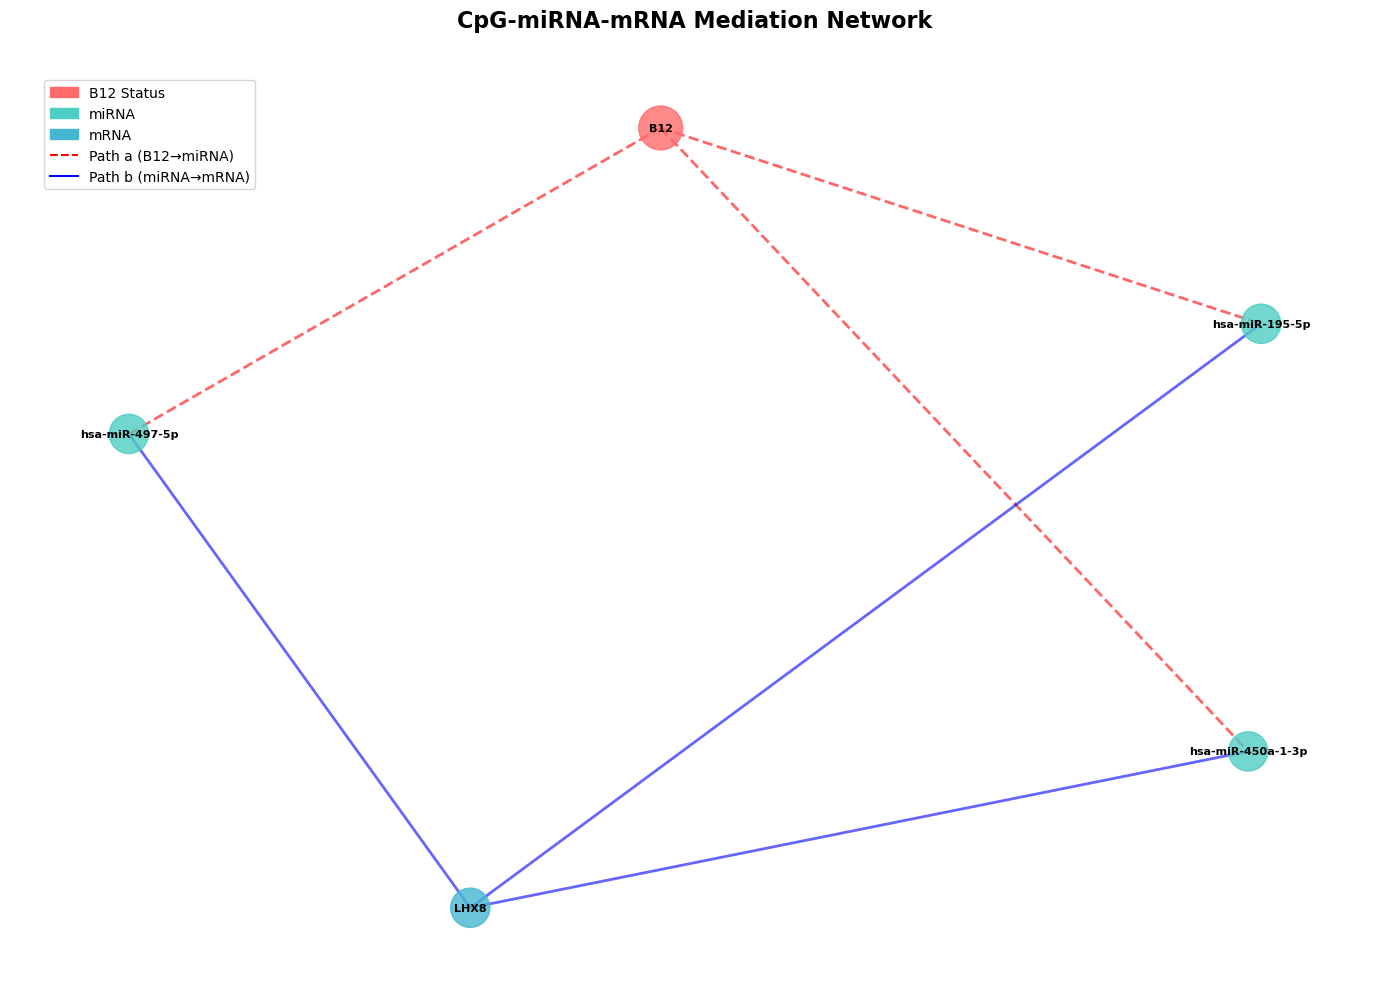

Saved: /Users/heweilin/Desktop/P056_Code/Figure/4_effect_size_analysis.png


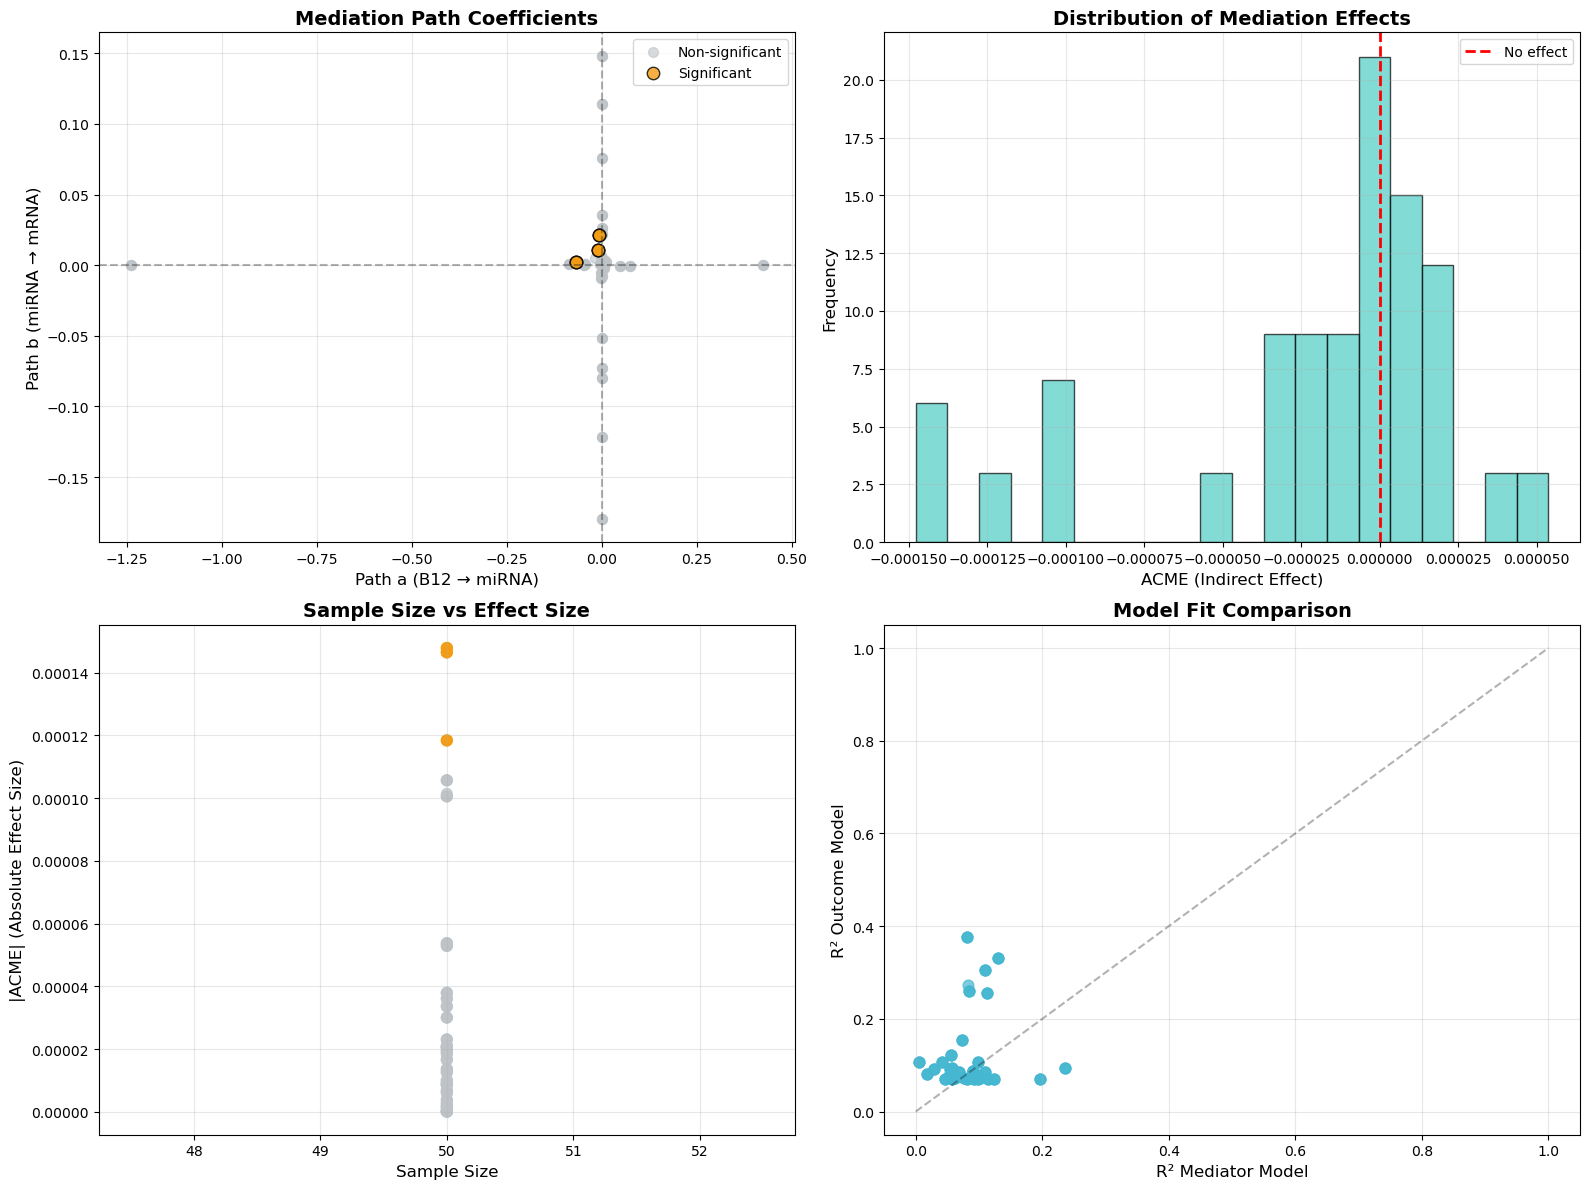

Saved: /Users/heweilin/Desktop/P056_Code/Figure/4_pathway_LHX8.png
LHX8 - miRNA: hsa-miR-450a-1-3p, ACME: -0.0001


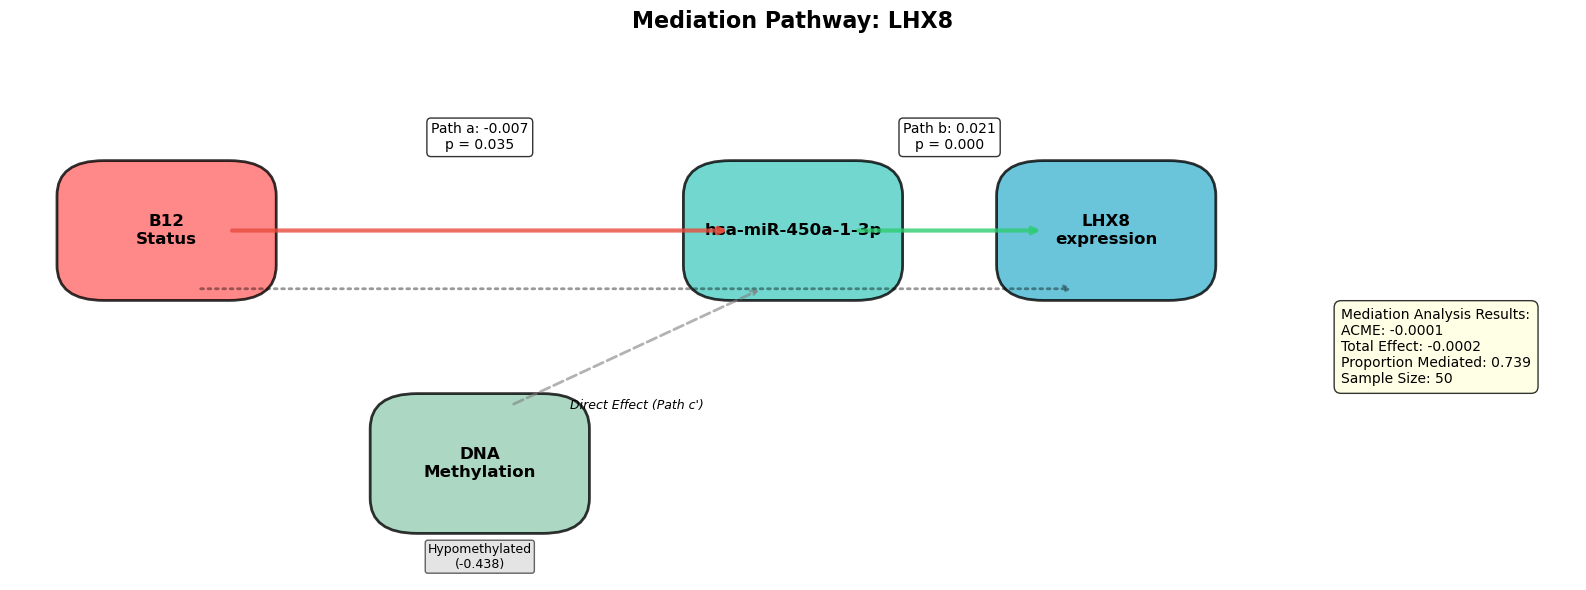

Saved: /Users/heweilin/Desktop/P056_Code/Figure/4_mediation_summary.png


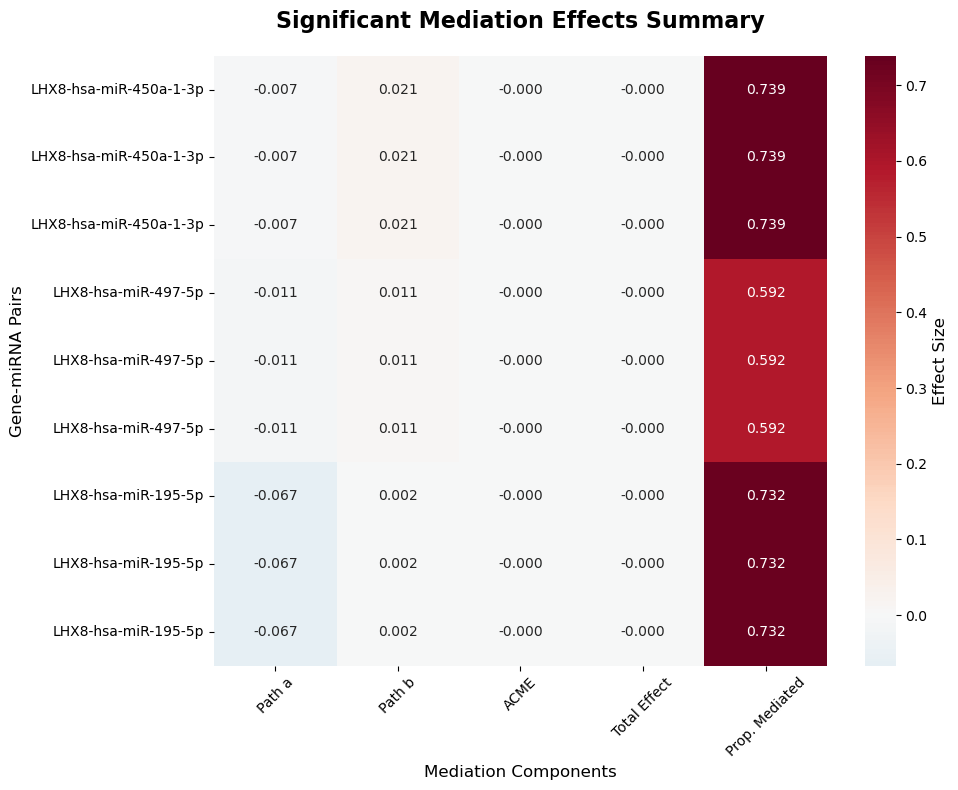

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# Define color schemes
colors = {
    'B12': '#FF6B6B',           # Red for B12
    'miRNA': '#4ECDC4',         # Teal for miRNA
    'mRNA': '#45B7D1',          # Blue for mRNA
    'methylation': '#96CEB4',   # Green for methylation
    'positive': '#2ECC71',      # Green for positive effects
    'negative': '#E74C3C',      # Red for negative effects
    'significant': '#F39C12',   # Orange for significant
    'non_significant': '#BDC3C7' # Gray for non-significant
}

def load_mediation_data(base_dir):
    """Load all mediation analysis results"""
    
    print("Loading mediation analysis data...")
    
    # File paths with timestamp
    timestamp = "20250725_160839"
    files = {
        'complete': f"Complete_Mediation_Results_{timestamp}.csv",
        'significant': f"Significant_Mediation_Results_{timestamp}.csv",
        'summary': f"Mediation_Results_Summary_{timestamp}.csv",
        'triplets': f"Mediation_Triplets_{timestamp}.csv"
    }
    
    data = {}
    for key, filename in files.items():
        filepath = f"{base_dir}/{filename}"
        try:
            data[key] = pd.read_csv(filepath)
            print(f"  Loaded {key}: {len(data[key])} records")
        except Exception as e:
            print(f"  Warning: Could not load {key} - {e}")
            data[key] = pd.DataFrame()
    
    return data

def create_mediation_network(significant_results, title="Mediation Network", max_nodes=20):
    """Create a network graph showing mediation relationships"""
    
    if len(significant_results) == 0:
        print("No significant results to visualize")
        return None
    
    # Limit to top results to avoid overcrowding
    top_results = significant_results.head(max_nodes)
    
    # Create network graph
    G = nx.Graph()
    
    # Add nodes and edges
    for _, row in top_results.iterrows():
        gene = row['Gene_Symbol']
        mirna = row['miRNA_Name']
        
        # Add nodes with attributes
        G.add_node(f"B12", node_type='B12', size=1000)
        G.add_node(mirna, node_type='miRNA', size=800)
        G.add_node(gene, node_type='mRNA', size=800)
        
        # Add edges with weights based on effect sizes
        acme = abs(row['ACME'])
        path_a = abs(row['Path_a'])
        path_b = abs(row['Path_b'])
        
        G.add_edge("B12", mirna, weight=path_a, edge_type='path_a')
        G.add_edge(mirna, gene, weight=path_b, edge_type='path_b')
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Draw nodes by type
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        node_data = G.nodes[node]
        if node_data['node_type'] == 'B12':
            node_colors.append(colors['B12'])
        elif node_data['node_type'] == 'miRNA':
            node_colors.append(colors['miRNA'])
        else:  # mRNA
            node_colors.append(colors['mRNA'])
        node_sizes.append(node_data['size'])
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                          alpha=0.8, ax=ax)
    
    # Draw edges with different styles for different paths
    path_a_edges = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'path_a']
    path_b_edges = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'path_b']
    
    nx.draw_networkx_edges(G, pos, edgelist=path_a_edges, edge_color='red', 
                          width=2, alpha=0.6, style='--', ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=path_b_edges, edge_color='blue', 
                          width=2, alpha=0.6, style='-', ax=ax)
    
    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)
    
    # Create legend
    legend_elements = [
        mpatches.Patch(color=colors['B12'], label='B12 Status'),
        mpatches.Patch(color=colors['miRNA'], label='miRNA'),
        mpatches.Patch(color=colors['mRNA'], label='mRNA'),
        plt.Line2D([0], [0], color='red', linestyle='--', label='Path a (B12→miRNA)'),
        plt.Line2D([0], [0], color='blue', linestyle='-', label='Path b (miRNA→mRNA)')
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98))
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    return fig

def create_pathway_diagram(gene_data, title="Mediation Pathway"):
    """Create a detailed pathway diagram for a specific gene"""
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Define positions for pathway elements
    positions = {
        'B12': (1, 3),
        'methylation': (3, 1),
        'miRNA': (5, 3),
        'mRNA': (7, 3)
    }
    
    # Define box styles and colors
    box_props = {
        'boxstyle': 'round,pad=0.3',
        'alpha': 0.8,
        'edgecolor': 'black',
        'linewidth': 2
    }
    
    # Draw pathway elements
    elements = {}
    
    # B12 Status
    elements['B12'] = FancyBboxPatch(
        (positions['B12'][0]-0.4, positions['B12'][1]-0.3), 0.8, 0.6,
        facecolor=colors['B12'], **box_props
    )
    ax.add_patch(elements['B12'])
    ax.text(positions['B12'][0], positions['B12'][1], 'B12\nStatus', 
            ha='center', va='center', fontweight='bold', fontsize=12)
    
    # DNA Methylation
    elements['methylation'] = FancyBboxPatch(
        (positions['methylation'][0]-0.4, positions['methylation'][1]-0.3), 0.8, 0.6,
        facecolor=colors['methylation'], **box_props
    )
    ax.add_patch(elements['methylation'])
    ax.text(positions['methylation'][0], positions['methylation'][1], 'DNA\nMethylation', 
            ha='center', va='center', fontweight='bold', fontsize=12)
    
    # miRNA
    mirna_name = gene_data.get('miRNA_Name', 'miRNA')
    elements['miRNA'] = FancyBboxPatch(
        (positions['miRNA'][0]-0.4, positions['miRNA'][1]-0.3), 0.8, 0.6,
        facecolor=colors['miRNA'], **box_props
    )
    ax.add_patch(elements['miRNA'])
    ax.text(positions['miRNA'][0], positions['miRNA'][1], f'{mirna_name}', 
            ha='center', va='center', fontweight='bold', fontsize=12)
    
    # mRNA/Gene
    gene_name = gene_data.get('Gene_Symbol', 'Gene')
    elements['mRNA'] = FancyBboxPatch(
        (positions['mRNA'][0]-0.4, positions['mRNA'][1]-0.3), 0.8, 0.6,
        facecolor=colors['mRNA'], **box_props
    )
    ax.add_patch(elements['mRNA'])
    ax.text(positions['mRNA'][0], positions['mRNA'][1], f'{gene_name}\nexpression', 
            ha='center', va='center', fontweight='bold', fontsize=12)
    
    # Draw arrows and add effect information
    arrow_props = dict(arrowstyle='->', lw=3, alpha=0.8)
    
    # Path a: B12 -> miRNA
    path_a = gene_data.get('Path_a', 0)
    path_a_p = gene_data.get('Path_a_pvalue', 1)
    arrow_color = colors['positive'] if path_a > 0 else colors['negative']
    
    ax.annotate('', xy=(positions['miRNA'][0]-0.4, positions['miRNA'][1]), 
                xytext=(positions['B12'][0]+0.4, positions['B12'][1]),
                arrowprops={**arrow_props, 'color': arrow_color})
    
    # Add path coefficient
    mid_x = (positions['B12'][0] + positions['miRNA'][0]) / 2
    ax.text(mid_x, positions['B12'][1] + 0.8, f'Path a: {path_a:.3f}\np = {path_a_p:.3f}', 
            ha='center', va='center', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Path b: miRNA -> mRNA
    path_b = gene_data.get('Path_b', 0)
    path_b_p = gene_data.get('Path_b_pvalue', 1)
    arrow_color = colors['positive'] if path_b > 0 else colors['negative']
    
    ax.annotate('', xy=(positions['mRNA'][0]-0.4, positions['mRNA'][1]), 
                xytext=(positions['miRNA'][0]+0.4, positions['miRNA'][1]),
                arrowprops={**arrow_props, 'color': arrow_color})
    
    ax.text((positions['miRNA'][0] + positions['mRNA'][0]) / 2, 
            positions['miRNA'][1] + 0.8, f'Path b: {path_b:.3f}\np = {path_b_p:.3f}', 
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Methylation influence (contextual)
    meth_direction = gene_data.get('Methylation_Direction', 'Unknown')
    meth_value = gene_data.get('Methylation_Value', 0)
    
    ax.annotate('', xy=(positions['miRNA'][0]-0.2, positions['miRNA'][1]-0.5), 
                xytext=(positions['methylation'][0]+0.2, positions['methylation'][1]+0.5),
                arrowprops=dict(arrowstyle='->', lw=2, alpha=0.6, color='gray', linestyle='--'))
    
    ax.text(positions['methylation'][0], positions['methylation'][1] - 0.8, 
            f'{meth_direction}\n({meth_value:.3f})', 
            ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.2', facecolor='lightgray', alpha=0.6))
    
    # Add mediation effect information
    acme = gene_data.get('ACME', 0)
    total_effect = gene_data.get('Total_Effect', 0)
    prop_mediated = gene_data.get('Proportion_Mediated', 0)
    
    # Direct effect (dashed line)
    ax.annotate('', xy=(positions['mRNA'][0]-0.2, positions['mRNA'][1]-0.5), 
                xytext=(positions['B12'][0]+0.2, positions['B12'][1]-0.5),
                arrowprops=dict(arrowstyle='->', lw=2, alpha=0.4, color='black', linestyle=':'))
    
    ax.text((positions['B12'][0] + positions['mRNA'][0]) / 2, 1.5, 
            'Direct Effect (Path c\')', 
            ha='center', va='center', fontsize=9, style='italic')
    
    # Add summary statistics box
    stats_text = f"""Mediation Analysis Results:
ACME: {acme:.4f}
Total Effect: {total_effect:.4f}
Proportion Mediated: {prop_mediated:.3f}
Sample Size: {gene_data.get('Sample_Size', 'N/A')}"""
    
    ax.text(8.5, 2, stats_text, ha='left', va='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))
    
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 4.5)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    return fig

def create_effect_size_plot(complete_results):
    """Create scatter plots showing effect sizes and significance"""
    
    if len(complete_results) == 0:
        print("No data available for effect size visualization")
        return None
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Path a vs Path b scatter plot
    ax1 = axes[0, 0]
    significant = complete_results['Mediation_Significant'] == True
    
    scatter = ax1.scatter(complete_results.loc[~significant, 'Path_a'], 
                         complete_results.loc[~significant, 'Path_b'],
                         c=colors['non_significant'], alpha=0.6, s=50, label='Non-significant')
    
    if significant.any():
        ax1.scatter(complete_results.loc[significant, 'Path_a'], 
                   complete_results.loc[significant, 'Path_b'],
                   c=colors['significant'], alpha=0.8, s=80, label='Significant', edgecolor='black')
    
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Path a (B12 → miRNA)', fontsize=12)
    ax1.set_ylabel('Path b (miRNA → mRNA)', fontsize=12)
    ax1.set_title('Mediation Path Coefficients', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. ACME distribution
    ax2 = axes[0, 1]
    acme_values = complete_results['ACME'].dropna()
    
    ax2.hist(acme_values, bins=20, alpha=0.7, color=colors['miRNA'], edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No effect')
    ax2.set_xlabel('ACME (Indirect Effect)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Mediation Effects', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Sample size vs effect size
    ax3 = axes[1, 0]
    sample_sizes = complete_results['Sample_Size']
    acme_abs = np.abs(complete_results['ACME'])
    
    scatter = ax3.scatter(sample_sizes, acme_abs, 
                         c=complete_results['Mediation_Significant'].map({True: colors['significant'], 
                                                                         False: colors['non_significant']}),
                         alpha=0.7, s=60)
    
    ax3.set_xlabel('Sample Size', fontsize=12)
    ax3.set_ylabel('|ACME| (Absolute Effect Size)', fontsize=12)
    ax3.set_title('Sample Size vs Effect Size', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Model fit comparison
    ax4 = axes[1, 1]
    r2_mediator = complete_results['R2_Mediator'].dropna()
    r2_outcome = complete_results['R2_Outcome'].dropna()
    
    ax4.scatter(r2_mediator, r2_outcome, alpha=0.7, s=60, color=colors['mRNA'])
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax4.set_xlabel('R² Mediator Model', fontsize=12)
    ax4.set_ylabel('R² Outcome Model', fontsize=12)
    ax4.set_title('Model Fit Comparison', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_gene_specific_analysis(significant_results, gene_name="LHX8"):
    """Create detailed visualization for a specific gene"""
    
    gene_data = significant_results[significant_results['Gene_Symbol'] == gene_name]
    
    if len(gene_data) == 0:
        print(f"No significant results found for {gene_name}")
        # Try to find the gene in all results or suggest alternatives
        all_genes = significant_results['Gene_Symbol'].unique()
        if len(all_genes) > 0:
            print(f"Available genes: {', '.join(all_genes[:10])}")
            # Use the first available gene as example
            gene_name = all_genes[0]
            gene_data = significant_results[significant_results['Gene_Symbol'] == gene_name]
        else:
            return None
    
    if len(gene_data) > 1:
        # If multiple entries, take the one with largest absolute ACME
        gene_data = gene_data.loc[gene_data['ACME'].abs().idxmax()].to_dict()
    else:
        gene_data = gene_data.iloc[0].to_dict()
    
    # Create pathway diagram
    title = f"Mediation Pathway: {gene_name}"
    fig = create_pathway_diagram(gene_data, title)
    
    return fig, gene_data

def create_summary_heatmap(significant_results):
    """Create a heatmap summary of significant mediation effects"""
    
    if len(significant_results) == 0:
        return None
    
    # Prepare data for heatmap
    top_results = significant_results.head(15)  # Top 15 for readability
    
    # Create matrix for heatmap
    heatmap_data = []
    labels = []
    
    for _, row in top_results.iterrows():
        gene = row['Gene_Symbol']
        mirna = row['miRNA_Name']
        label = f"{gene}-{mirna}"
        labels.append(label)
        
        heatmap_data.append([
            row['Path_a'],
            row['Path_b'], 
            row['ACME'],
            row['Total_Effect'],
            row['Proportion_Mediated']
        ])
    
    heatmap_df = pd.DataFrame(heatmap_data, 
                             columns=['Path a', 'Path b', 'ACME', 'Total Effect', 'Prop. Mediated'],
                             index=labels)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Effect Size'}, ax=ax)
    
    ax.set_title('Significant Mediation Effects Summary', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Mediation Components', fontsize=12)
    ax.set_ylabel('Gene-miRNA Pairs', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return fig

# Set paths
base_dir = "/Users/heweilin/Desktop/P056_Code/Data_Post_Processed"
figure_dir = "/Users/heweilin/Desktop/P056_Code/Figure"

# Load data
data = load_mediation_data(base_dir)

if len(data['significant']) == 0:
    print("No significant results found. Using complete results...")
    significant_data = data['complete'].head(10) if len(data['complete']) > 0 else pd.DataFrame()
else:
    significant_data = data['significant']

# 1. Network diagram
if len(significant_data) > 0:
    fig_network = create_mediation_network(significant_data, "CpG-miRNA-mRNA Mediation Network")
    if fig_network:
        fig_network.savefig(f"{figure_dir}/4_mediation_network.png", dpi=300, bbox_inches='tight')
        print(f"Saved: {figure_dir}/4_mediation_network.png")
        plt.show()

# 2. Effect size analysis
if len(data['complete']) > 0:
    fig_effects = create_effect_size_plot(data['complete'])
    if fig_effects:
        fig_effects.savefig(f"{figure_dir}/4_effect_size_analysis.png", dpi=300, bbox_inches='tight')
        print(f"Saved: {figure_dir}/4_effect_size_analysis.png")
        plt.show()

# 3. Gene-specific pathway (LHX8 or first available gene)
if len(significant_data) > 0:
    for gene_name in ['LHX8'] + list(significant_data['Gene_Symbol'].unique()[:3]):
        result = create_gene_specific_analysis(significant_data, gene_name)
        if result:
            fig_pathway, gene_info = result
            fig_pathway.savefig(f"{figure_dir}/4_pathway_{gene_name}.png", dpi=300, bbox_inches='tight')
            print(f"Saved: {figure_dir}/4_pathway_{gene_name}.png")
            print(f"{gene_name} - miRNA: {gene_info.get('miRNA_Name', 'N/A')}, ACME: {gene_info.get('ACME', 0):.4f}")
            plt.show()
            break

# 4. Summary heatmap
if len(significant_data) > 0:
    fig_summary = create_summary_heatmap(significant_data)
    if fig_summary:
        fig_summary.savefig(f"{figure_dir}/4_mediation_summary.png", dpi=300, bbox_inches='tight')
        print(f"Saved: {figure_dir}/4_mediation_summary.png")
        plt.show()